In [1]:
import math

from random import shuffle, sample, random

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tempfile import NamedTemporaryFile

%matplotlib inline

/Users/tolparow/.local/share/virtualenvs/PMLDL-QXcnivgp/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/tolparow/.local/share/virtualenvs/PMLDL-QXcnivgp/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Task 2

In [2]:
# Read cities, fix population column, get first 30
def remove_brackets(s):
  return s[:s.index('[')] if '[' in s else s

cities = pd.read_csv('city.csv')
cities['population'] = cities['population'].map(remove_brackets)
cities = cities.astype({'population': 'int32'}) \
  .sort_values(by=['population'], ascending=False)[:30]

In [3]:
cities

address  postal_code country  \
509                                       г Москва     101000.0  Россия   
786                              г Санкт-Петербург     190000.0  Россия   
647                                  г Новосибирск     630000.0  Россия   
832                                 г Екатеринбург     620000.0  Россия   
619                              г Нижний Новгород     603000.0  Россия   
927                                       г Казань     420000.0  Россия   
782                                       г Самара     443000.0  Россия   
656                                         г Омск     644000.0  Россия   
1064                                   г Челябинск     454000.0  Россия   
757                               г Ростов-на-Дону     344000.0  Россия   
62                                           г Уфа     450000.0  Россия   
121                                    г Волгоград     400000.0  Россия   
706                                        г Пермь     614000.0  Россия   
411                                   г Красноярск     660000.0  Россия   
159                                      г Воронеж     394000.0  Россия   
801                                      г Саратов     410000.0  Россия   
381                                    г Краснодар     350000.0  Россия   
784                      Самарская обл, г Тольятти     445000.0  Россия   
4                                        г Барнаул     656000.0  Россия   
999                                       г Ижевск     426000.0  Россия   
1008                                   г Ульяновск     432000.0  Россия   
717                                  г Владивосток     690000.0  Россия   
1116                                   г Ярославль     150000.0  Россия   
223                                      г Иркутск     664000.0  Россия   
995                        Тюменская обл, г Тюмень     625000.0  Россия   
177                                    г Махачкала     367000.0  Россия   
1015                                   г Хабаровск     680000.0  Россия   
666                                     г Оренбург     460000.0  Россия   
322   Кемеровская область - Кузбасс, г Новокузнецк     654000.0  Россия   
316                                     г Кемерово     650000.0  Россия   

       federal_district region_type                         region area_type  \
509         Центральный           г                         Москва       NaN   
786     Северо-Западный           г                Санкт-Петербург       NaN   
647           Сибирский         обл                  Новосибирская       NaN   
832           Уральский         обл                   Свердловская       NaN   
619         Приволжский         обл                  Нижегородская       NaN   
927         Приволжский        Респ                      Татарстан       NaN   
782         Приволжский         обл                      Самарская       NaN   
656           Сибирский         обл                         Омская       NaN   
1064          Уральский         обл                    Челябинская       NaN   
757               Южный         обл                     Ростовская       NaN   
62          Приволжский        Респ                   Башкортостан       NaN   
121               Южный         обл                  Волгоградская       NaN   
706         Приволжский        край                       Пермский       NaN   
411           Сибирский        край                   Красноярский       NaN   
159         Центральный         обл                    Воронежская       NaN   
801         Приволжский         обл                    Саратовская       NaN   
381               Южный        край                  Краснодарский       NaN   
784         Приволжский         обл                      Самарская       NaN   
4             Сибирский        край                      Алтайский       NaN   
999         Приволжский        Респ                     Удмуртская       NaN   
1008        Приволжский         обл  

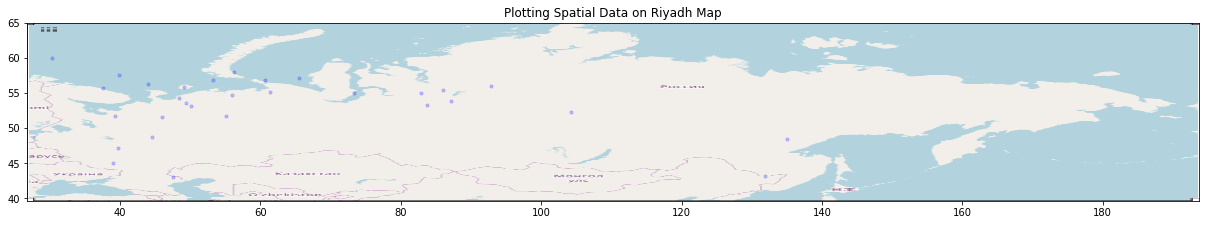

In [4]:
map_bbox = (26.72, 193.71, 39.64, 77.80,) # long_min, long_max, lat_min, lat_max
map_bbox = (26.72, 193.71, 39.64, 65.00,)

rus_map = plt.imread('map.png')

fig, ax = plt.subplots(figsize = (21,20))
ax.scatter(cities.geo_lon, cities.geo_lat, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on Riyadh Map')
ax.set_xlim(map_bbox[0],map_bbox[1])
ax.set_ylim(map_bbox[2],map_bbox[3])
ax.imshow(rus_map, zorder=0, extent = map_bbox, aspect= 'equal')

In [82]:
def geo_dist(lat1, lon1, lat2, lon2):
    radius = 6371
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return radius * c

def adjacency_matrix(df):
  matrix = dict()
  city_list = list()
  for city1 in df.iterrows():
    city_list.append(city1[0])
    for city2 in df.iterrows():
      if city1[0] != city2[0]:
        dist = geo_dist(city1[1]['geo_lat'], city1[1]['geo_lon'], 
                        city2[1]['geo_lat'], city2[1]['geo_lon'])
        if city1[0] in matrix:
          matrix[city1[0]][city2[0]] = dist
        else:
          matrix[city1[0]] = {city2[0] : dist}
        
        if city2[0] in matrix:
          matrix[city2[0]][city1[0]] = dist
        else:
          matrix[city2[0]] = {city1[0] : dist}

  return matrix, city_list


def path_length(solution, adj_matrix):
  return sum([adj_matrix[c1][c2] for c1, c2 in 
              zip(solution, solution[1:] + [solution[0]])])

def draw_history(cities, history, map_box):
    fig, ax = plt.subplots()

    line, = plt.plot([], [], lw=5)
    
    ax.set_xlim(map_bbox[0],map_bbox[1])
    ax.set_ylim(map_bbox[2],map_bbox[3])
    
    def init():
        x = [cities.loc[i]['geo_lon'] for i in history[0]]
        y = [cities.loc[i]['geo_lat'] for i in history[0]]
        plt.plot(x, y, 'bo')

        line.set_data(x, y)
        return line,
    
    def update(frame):
        x = [cities.loc[i]['geo_lon'] for i in history[frame]]
        y = [cities.loc[i]['geo_lat'] for i in history[frame]]
        line.set_data(x, y)
        return line,
    
    animation = FuncAnimation(fig, update, 
                              frames=range(0, len(history), len(history) // 100),
                              init_func=init, repeat=True)
    return animation

In [71]:
class PathAnnealing:
    def __init__(self, T, a, max_iter, cities, map_box):
        self.T = T
        self.a = a
        self.max_iter = max_iter
        self.cities = cities
        self.map_box = map_box

        self.i = 0

        self.adj_matrix, self.curr_path = adjacency_matrix(self.cities)

        # Random shuffle initial path
        shuffle(self.curr_path)
        self.best_path = self.curr_path.copy()

        self.curr_length = path_length(self.curr_path, self.adj_matrix)
        self.min_length = self.curr_length

        self.n = len(self.curr_path)
        
        self.history = list()

    def accept_ratio(self, proposed_length):
        return math.exp((self.curr_length - proposed_length) / self.T)

    def accept(self, proposed_path):
        proposed_length = path_length(proposed_path, self.adj_matrix)

        if (proposed_length < self.curr_length) or (random() < self.accept_ratio(proposed_length)):
            self.curr_length = proposed_length
            self.curr_path = proposed_path
            
            self.history.append(self.curr_path.copy())

            if self.curr_length < self.min_length:
                self.min_length = self.curr_length
                self.best_path = self.curr_path.copy()

    def anneal_rand_exchange(self):
      while self.T > 0 and self.i < self.max_iter:
        c1, c2 = sample(range(0, self.n), 2)
        proposed_path = self.curr_path.copy()
        proposed_path[c1], proposed_path[c2] = proposed_path[c2], proposed_path[c1]

        self.accept(proposed_path)

        self.T *= self.a
        self.i += 1
        
        if not self.i % 100:
            print(f'it: {self.i}, current length: {int(self.curr_length)}, '
                  f'min length: {int(self.min_length)}, '
                  f'temp: {int(self.T)}')
        
    def draw_history(self):
        return draw_history(self.cities, self.history, self.map_box)

In [74]:
anneal = PathAnnealing(10000.0, 0.9999, 1e5, cities, map_bbox)

In [75]:
anneal.anneal_rand_exchange()

it: 100, current length: 52863, min length: 49815, temp: 9900
it: 200, current length: 62934, min length: 49815, temp: 9801
it: 300, current length: 64518, min length: 42826, temp: 9704
it: 400, current length: 59699, min length: 42826, temp: 9607
it: 500, current length: 55125, min length: 42826, temp: 9512
it: 600, current length: 60991, min length: 42826, temp: 9417
it: 700, current length: 62092, min length: 42826, temp: 9323
it: 800, current length: 54853, min length: 42826, temp: 9231
it: 900, current length: 55048, min length: 42826, temp: 9139
it: 1000, current length: 58684, min length: 42826, temp: 9048
it: 1100, current length: 56724, min length: 42826, temp: 8958
it: 1200, current length: 51045, min length: 42826, temp: 8869
it: 1300, current length: 53082, min length: 42826, temp: 8780
it: 1400, current length: 58440, min length: 42826, temp: 8693
it: 1500, current length: 47848, min length: 42826, temp: 8607
it: 1600, current length: 61396, min length: 42826, temp: 8521
i

it: 13500, current length: 51828, min length: 33518, temp: 2592
it: 13600, current length: 43521, min length: 33518, temp: 2566
it: 13700, current length: 55077, min length: 33518, temp: 2540
it: 13800, current length: 55424, min length: 33518, temp: 2515
it: 13900, current length: 55833, min length: 33518, temp: 2490
it: 14000, current length: 43475, min length: 33518, temp: 2465
it: 14100, current length: 45419, min length: 33518, temp: 2441
it: 14200, current length: 45748, min length: 33518, temp: 2416
it: 14300, current length: 55553, min length: 33518, temp: 2392
it: 14400, current length: 46602, min length: 33518, temp: 2369
it: 14500, current length: 52856, min length: 33518, temp: 2345
it: 14600, current length: 45738, min length: 33518, temp: 2322
it: 14700, current length: 44127, min length: 33518, temp: 2299
it: 14800, current length: 52748, min length: 33518, temp: 2276
it: 14900, current length: 46671, min length: 33518, temp: 2253
it: 15000, current length: 40911, min le

it: 26800, current length: 34251, min length: 25164, temp: 685
it: 26900, current length: 31847, min length: 25164, temp: 678
it: 27000, current length: 31177, min length: 25164, temp: 671
it: 27100, current length: 29454, min length: 25164, temp: 665
it: 27200, current length: 24241, min length: 24241, temp: 658
it: 27300, current length: 29833, min length: 24109, temp: 652
it: 27400, current length: 27846, min length: 24109, temp: 645
it: 27500, current length: 27897, min length: 24109, temp: 639
it: 27600, current length: 24778, min length: 24109, temp: 632
it: 27700, current length: 26716, min length: 24109, temp: 626
it: 27800, current length: 27188, min length: 24109, temp: 620
it: 27900, current length: 28433, min length: 24109, temp: 614
it: 28000, current length: 31681, min length: 24109, temp: 608
it: 28100, current length: 27445, min length: 24109, temp: 601
it: 28200, current length: 24824, min length: 24109, temp: 595
it: 28300, current length: 30523, min length: 24109, te

it: 40900, current length: 20259, min length: 18341, temp: 167
it: 41000, current length: 21135, min length: 18341, temp: 165
it: 41100, current length: 19816, min length: 18341, temp: 164
it: 41200, current length: 19138, min length: 18341, temp: 162
it: 41300, current length: 19242, min length: 18341, temp: 160
it: 41400, current length: 19377, min length: 18341, temp: 159
it: 41500, current length: 18800, min length: 18341, temp: 157
it: 41600, current length: 18832, min length: 18341, temp: 156
it: 41700, current length: 19002, min length: 18341, temp: 154
it: 41800, current length: 18798, min length: 18341, temp: 152
it: 41900, current length: 19040, min length: 18341, temp: 151
it: 42000, current length: 19366, min length: 18341, temp: 149
it: 42100, current length: 19761, min length: 18341, temp: 148
it: 42200, current length: 20002, min length: 18341, temp: 146
it: 42300, current length: 19960, min length: 18341, temp: 145
it: 42400, current length: 19325, min length: 18341, te

it: 54000, current length: 18242, min length: 17990, temp: 45
it: 54100, current length: 18242, min length: 17990, temp: 44
it: 54200, current length: 18242, min length: 17990, temp: 44
it: 54300, current length: 18242, min length: 17990, temp: 43
it: 54400, current length: 18242, min length: 17990, temp: 43
it: 54500, current length: 18242, min length: 17990, temp: 42
it: 54600, current length: 18242, min length: 17990, temp: 42
it: 54700, current length: 18324, min length: 17990, temp: 42
it: 54800, current length: 18324, min length: 17990, temp: 41
it: 54900, current length: 18324, min length: 17990, temp: 41
it: 55000, current length: 18242, min length: 17990, temp: 40
it: 55100, current length: 18242, min length: 17990, temp: 40
it: 55200, current length: 18242, min length: 17990, temp: 40
it: 55300, current length: 18324, min length: 17990, temp: 39
it: 55400, current length: 18340, min length: 17990, temp: 39
it: 55500, current length: 18340, min length: 17990, temp: 38
it: 5560

it: 67900, current length: 17908, min length: 17908, temp: 11
it: 68000, current length: 17908, min length: 17908, temp: 11
it: 68100, current length: 17908, min length: 17908, temp: 11
it: 68200, current length: 17908, min length: 17908, temp: 10
it: 68300, current length: 17908, min length: 17908, temp: 10
it: 68400, current length: 17908, min length: 17908, temp: 10
it: 68500, current length: 17908, min length: 17908, temp: 10
it: 68600, current length: 17908, min length: 17908, temp: 10
it: 68700, current length: 17908, min length: 17908, temp: 10
it: 68800, current length: 17908, min length: 17908, temp: 10
it: 68900, current length: 17908, min length: 17908, temp: 10
it: 69000, current length: 17908, min length: 17908, temp: 10
it: 69100, current length: 17908, min length: 17908, temp: 9
it: 69200, current length: 17908, min length: 17908, temp: 9
it: 69300, current length: 17908, min length: 17908, temp: 9
it: 69400, current length: 17908, min length: 17908, temp: 9
it: 69500, c

it: 96000, current length: 17908, min length: 17908, temp: 0
it: 96100, current length: 17908, min length: 17908, temp: 0
it: 96200, current length: 17908, min length: 17908, temp: 0
it: 96300, current length: 17908, min length: 17908, temp: 0
it: 96400, current length: 17908, min length: 17908, temp: 0
it: 96500, current length: 17908, min length: 17908, temp: 0
it: 96600, current length: 17908, min length: 17908, temp: 0
it: 96700, current length: 17908, min length: 17908, temp: 0
it: 96800, current length: 17908, min length: 17908, temp: 0
it: 96900, current length: 17908, min length: 17908, temp: 0
it: 97000, current length: 17908, min length: 17908, temp: 0
it: 97100, current length: 17908, min length: 17908, temp: 0
it: 97200, current length: 17908, min length: 17908, temp: 0
it: 97300, current length: 17908, min length: 17908, temp: 0
it: 97400, current length: 17908, min length: 17908, temp: 0
it: 97500, current length: 17908, min length: 17908, temp: 0
it: 97600, current lengt

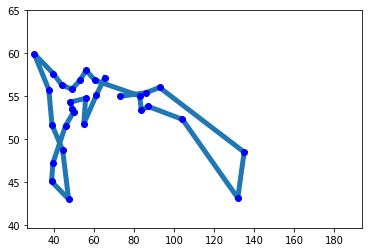

In [83]:
HTML(anneal.draw_history().to_html5_video())